# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'casa-random'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset-2/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset-2/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset-2/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend(random_indices)
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'pornografi': [y_train[i][0] for i in temp],
            'sara': [y_train[i][1] for i in temp],
            'radikalisme': [y_train[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train[i][3] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(
            current_train_size, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6756, Accuracy: 0.7731, F1 Micro: 0.8711, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5958, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5785, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.513, Accuracy: 0.7939, F1 Micro: 0.8843, F1 Macro: 0.8828
Epoch 5/10, Train Loss: 0.5006, Accuracy: 0.7924, F1 Micro: 0.8829, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4695, Accuracy: 0.7954, F1 Micro: 0.8846, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4328, Accuracy: 0.7969, F1 Micro: 0.8857, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.4369, Accuracy: 0.7932, F1 Micro: 0.8832, F1 Macro: 0.8812
Epoch 9/10, Train Loss: 0.415, Accuracy: 0.7917, F1 Micro: 0.8816, F1 Macro: 0.8789
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7162, Accuracy: 0.2857, F1 Micro: 0.2857, F1 Macro: 0.2222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6764, Accuracy: 0.5, F1 Micro: 0.5, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6621, Accuracy: 0.7143, F1 Micro: 0.7143, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.6053, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5803, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5674, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4789, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4895, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Epoch 9/10, Train Loss: 0.4054, Accuracy: 0.7143, F1 Micro: 0.7143,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6432, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5385, Accuracy: 0.7946, F1 Micro: 0.8831, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5044, Accuracy: 0.7969, F1 Micro: 0.8859, F1 Macro: 0.8844
Epoch 4/10, Train Loss: 0.4573, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4629, Accuracy: 0.8036, F1 Micro: 0.8892, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4123, Accuracy: 0.8147, F1 Micro: 0.8944, F1 Macro: 0.8936
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.399, Accuracy: 0.8274, F1 Micro: 0.9008, F1 Macro: 0.9001
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3713, Accuracy: 0.8475, F1 Micro: 0.9108, F1 Macro: 0.91
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.308, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6435, Accuracy: 0.7305, F1 Micro: 0.7305, F1 Macro: 0.4221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5578, Accuracy: 0.7305, F1 Micro: 0.7305, F1 Macro: 0.4221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4812, Accuracy: 0.8323, F1 Micro: 0.8323, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3747, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8565
Epoch 5/10, Train Loss: 0.2787, Accuracy: 0.8862, F1 Micro: 0.8862, F1 Macro: 0.8545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.155, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.88
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.124, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.899
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8871
Epoch 9/10, Train Loss: 0.1109, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8831
Epoch 10/10, Train Loss: 0.0812, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5935, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Epoch 2/10, Train Loss: 0.4979, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4727, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4302, Accuracy: 0.8058, F1 Micro: 0.8903, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4179, Accuracy: 0.8326, F1 Micro: 0.9036, F1 Macro: 0.9031
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3485, Accuracy: 0.8728, F1 Micro: 0.9244, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3022, Accuracy: 0.9077, F1 Micro: 0.9443, F1 Macro: 0.9431
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2486, Accuracy: 0.9323, F1 Micro: 0.958, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2041, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6185, Accuracy: 0.6851, F1 Micro: 0.6851, F1 Macro: 0.4066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5114, Accuracy: 0.7489, F1 Micro: 0.7489, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.396, Accuracy: 0.8936, F1 Micro: 0.8936, F1 Macro: 0.8701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1835, Accuracy: 0.9362, F1 Micro: 0.9362, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9489, F1 Micro: 0.9489, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9574, F1 Micro: 0.9574, F1 Macro: 0.951
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9357
Epoch 8/10, Train Loss: 0.104, Accuracy: 0.9362, F1 Micro: 0.9362, F1 Macro: 0.9273
Epoch 9/10, Train Loss: 0.0977, Accuracy: 0.9362, F1 Micro: 0.9362, F1 Macro: 0.9273
Epoch 10/10, Train Loss: 0.0938, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5812, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Epoch 2/10, Train Loss: 0.4868, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4542, Accuracy: 0.8125, F1 Micro: 0.8937, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.404, Accuracy: 0.8214, F1 Micro: 0.8983, F1 Macro: 0.8976
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3492, Accuracy: 0.8966, F1 Micro: 0.9378, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.285, Accuracy: 0.9241, F1 Micro: 0.9537, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2266, Accuracy: 0.9412, F1 Micro: 0.9637, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1864, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1471, Accuracy: 0.9531, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5919, Accuracy: 0.6752, F1 Micro: 0.6752, F1 Macro: 0.4031
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4793, Accuracy: 0.8462, F1 Micro: 0.8462, F1 Macro: 0.8064
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2661, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8973
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2612, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.9061
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9339
Epoch 7/10, Train Loss: 0.1595, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9226
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.088, Accuracy: 0.9402, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5734, Accuracy: 0.7954, F1 Micro: 0.8849, F1 Macro: 0.8832
Epoch 2/10, Train Loss: 0.486, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4562, Accuracy: 0.8177, F1 Micro: 0.8963, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3798, Accuracy: 0.8854, F1 Micro: 0.9317, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.295, Accuracy: 0.9353, F1 Micro: 0.9603, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2344, Accuracy: 0.9449, F1 Micro: 0.9659, F1 Macro: 0.9644
Epoch 7/10, Train Loss: 0.1827, Accuracy: 0.9442, F1 Micro: 0.9652, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1469, Accuracy: 0.9464, F1 Micro: 0.9664, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1192, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6034, Accuracy: 0.6935, F1 Micro: 0.6935, F1 Macro: 0.4219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4185, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.9089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2845, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.914
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9341
Epoch 6/10, Train Loss: 0.1573, Accuracy: 0.9355, F1 Micro: 0.9355, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.939
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9345
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9208
Epoch 10/10, Train Loss: 0.0489, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.564, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4698, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4119, Accuracy: 0.8594, F1 Micro: 0.9178, F1 Macro: 0.9175
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3163, Accuracy: 0.9286, F1 Micro: 0.9564, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2384, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1939, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9704
Epoch 7/10, Train Loss: 0.1451, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9679
Epoch 8/10, Train Loss: 0.1166, Accuracy: 0.9501, F1 Micro: 0.9687, F1 Macro: 0.966
Epoch 9/10, Train Loss: 0.0942, Accuracy: 0.9531, F1 Micro: 0.9705, F1 Macro: 0.9676
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5947, Accuracy: 0.6745, F1 Micro: 0.6745, F1 Macro: 0.4028
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4122, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2573, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9471
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9421
Epoch 5/10, Train Loss: 0.1671, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9386
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9227
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9389
Epoch 8/10, Train Loss: 0.1194, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9344
Epoch 9/10, Train Loss: 0.107, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9393
Epoch 10/10, Train Loss: 0.0779, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9344

Sentiment analysis accuracy: 0.9529, F1 Micro: 0.9529

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5642, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4846, Accuracy: 0.8162, F1 Micro: 0.8956, F1 Macro: 0.8951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4164, Accuracy: 0.875, F1 Micro: 0.9262, F1 Macro: 0.9259
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3058, Accuracy: 0.9353, F1 Micro: 0.9602, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2275, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1743, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Epoch 7/10, Train Loss: 0.1409, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.103, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0923, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.606, Accuracy: 0.8642, F1 Micro: 0.8642, F1 Macro: 0.8415
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3539, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2267, Accuracy: 0.9342, F1 Micro: 0.9342, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1556, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9424, F1 Micro: 0.9424, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9404
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.932
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.932
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5485, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4892, Accuracy: 0.8028, F1 Micro: 0.889, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4077, Accuracy: 0.8951, F1 Micro: 0.9374, F1 Macro: 0.937
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3051, Accuracy: 0.9442, F1 Micro: 0.9654, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.224, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1656, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1249, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5928, Accuracy: 0.6948, F1 Micro: 0.6948, F1 Macro: 0.5017
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3655, Accuracy: 0.9518, F1 Micro: 0.9518, F1 Macro: 0.947
Epoch 3/10, Train Loss: 0.161, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9339
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9289
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9421
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9293
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9328
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9375
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9116
Epoch 10/10, Train Loss: 0.1005, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9289

Sentiment analysis accuracy: 0.9518, F1 Micro: 0.9518, F1 Macro: 0.947
              

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5454, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4653, Accuracy: 0.8244, F1 Micro: 0.8992, F1 Macro: 0.899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3642, Accuracy: 0.9249, F1 Micro: 0.9543, F1 Macro: 0.9531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2549, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1902, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1088, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9786
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5734, Accuracy: 0.7328, F1 Micro: 0.7328, F1 Macro: 0.5923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2949, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9369
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9043
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9125
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8962
Epoch 7/10, Train Loss: 0.1477, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9278
Epoch 8/10, Train Loss: 0.0876, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9297
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9376
Epoch 10/10, Train Loss: 0.0558, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9329

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5427, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4666, Accuracy: 0.8229, F1 Micro: 0.8992, F1 Macro: 0.8986
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3588, Accuracy: 0.9271, F1 Micro: 0.9555, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2608, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1906, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1435, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.552, Accuracy: 0.82, F1 Micro: 0.82, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2682, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9386
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9295
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9132
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8917
Epoch 6/10, Train Loss: 0.1224, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9249
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9291
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9283
Epoch 9/10, Train Loss: 0.0853, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9249
Epoch 10/10, Train Loss: 0.0727, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9156

Sentiment analysis accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9386
              precision    recall  f1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5395, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4651, Accuracy: 0.849, F1 Micro: 0.9122, F1 Macro: 0.912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3486, Accuracy: 0.9338, F1 Micro: 0.9589, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2395, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1621, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0736, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5467, Accuracy: 0.851, F1 Micro: 0.851, F1 Macro: 0.8112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2848, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9386
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9386
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9428
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9306
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9223
Epoch 8/10, Train Loss: 0.0958, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9336
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9336
Epoch 10/10, Train Loss: 0.0544, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5466, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4536, Accuracy: 0.8415, F1 Micro: 0.9085, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.328, Accuracy: 0.9353, F1 Micro: 0.9599, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2298, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.167, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0673, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5107, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2342, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1755, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9381
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.943
Epoch 6/10, Train Loss: 0.0742, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9032
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9381
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.928
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9222
Epoch 10/10, Train Loss: 0.0639, Accuracy: 0.937, F1 Micro: 0.937, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5501, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4509, Accuracy: 0.8363, F1 Micro: 0.9061, F1 Macro: 0.9053
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3256, Accuracy: 0.9382, F1 Micro: 0.9618, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2274, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.541, Accuracy: 0.8677, F1 Micro: 0.8677, F1 Macro: 0.836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1689, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9305
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.9029
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9305
Epoch 7/10, Train Loss: 0.1142, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9264
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9268
Epoch 9/10, Train Loss: 0.0833, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9255
Epoch 10/10, Train Loss: 0.0602, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9172

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5394, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4427, Accuracy: 0.8951, F1 Micro: 0.9375, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2957, Accuracy: 0.9375, F1 Micro: 0.9609, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2062, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5518, Accuracy: 0.761, F1 Micro: 0.761, F1 Macro: 0.6461
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2729, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9466
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9339
Epoch 5/10, Train Loss: 0.1023, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.9424
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9377
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.928
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9381
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9223
Epoch 10/10, Train Loss: 0.06, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.9427

Sentiment analysis accuracy: 0.9522, F1 Micro: 0.9522, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5358, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4258, Accuracy: 0.8988, F1 Micro: 0.9392, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2938, Accuracy: 0.9449, F1 Micro: 0.9657, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2033, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9786
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5088, Accuracy: 0.8727, F1 Micro: 0.8727, F1 Macro: 0.8449
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2496, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9282
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9051
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.933
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.937
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9366
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.906
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9326
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.933
Epoch 10/10, Train Loss: 0.0637, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5318, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.446, Accuracy: 0.8757, F1 Micro: 0.9264, F1 Macro: 0.9263
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2909, Accuracy: 0.9472, F1 Micro: 0.9673, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1969, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1115, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9774
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5125, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2721, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.9022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1847, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9339
Epoch 4/10, Train Loss: 0.1216, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9289
Epoch 5/10, Train Loss: 0.1066, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9312
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9301
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9251
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9226
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.92
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9209

Sentiment analysis accuracy: 0.9409, F1 Micro: 0.9409, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5286, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4129, Accuracy: 0.9115, F1 Micro: 0.9465, F1 Macro: 0.9456
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2747, Accuracy: 0.9487, F1 Micro: 0.9682, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1928, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5306, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2221, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1405, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9112
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1353, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9351
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9257
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9348
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8981
Epoch 10/10, Train Loss: 0.0619, Accuracy:

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4171, Accuracy: 0.9174, F1 Micro: 0.9499, F1 Macro: 0.9492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2708, Accuracy: 0.9487, F1 Micro: 0.9683, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9733
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.975
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5016, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2408, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9266
Epoch 5/10, Train Loss: 0.1009, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.918
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8875
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.913
Epoch 8/10, Train Loss: 0.0783, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8875
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.923
Epoch 10/10, Train Loss: 0.078, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.918

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5343, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4235, Accuracy: 0.9122, F1 Micro: 0.9462, F1 Macro: 0.9443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2749, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9799
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Higher F1 achieved, s

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4709, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9099
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8929
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9356
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9278
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9278
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9253
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9349
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Epoch 10/10, Train Loss: 0.0571, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9315

Sentiment analysis accuracy: 0.9421, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5389, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4145, Accuracy: 0.9182, F1 Micro: 0.95, F1 Macro: 0.9485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2677, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.977

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4619, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9071
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.241, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9265
Epoch 3/10, Train Loss: 0.1641, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8996
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9123
Epoch 5/10, Train Loss: 0.1031, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0826, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9294
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5289, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3867, Accuracy: 0.9301, F1 Micro: 0.957, F1 Macro: 0.9553
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2502, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9788
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4659, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8933
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2356, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.9069
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1625, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9283
Epoch 4/10, Train Loss: 0.128, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9177
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9251
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9243
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9251
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9243
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9189
Epoch 10/10, Train Loss: 0.0418, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9144

Sentiment analysis accuracy: 0.9366, F1 Micro: 0.93

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5321, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4117, Accuracy: 0.9167, F1 Micro: 0.9492, F1 Macro: 0.948
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2557, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9804
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9792
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4771, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.9102
Epoch 2/10, Train Loss: 0.2097, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8997
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.9068
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9157
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.9026
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9162
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.925
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.918
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9136
Epoch 10/10, Train Loss: 0.0705, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.9059

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5305, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3887, Accuracy: 0.9323, F1 Micro: 0.9584, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2479, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 9/10, Train Loss: 0.0506, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4617, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9166
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2231, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.933
Epoch 3/10, Train Loss: 0.1456, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9407
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9171
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9175
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9359
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9314
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9223

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5224, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3887, Accuracy: 0.933, F1 Micro: 0.9589, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2408, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9692
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9712
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4551, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9219
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9137
Epoch 4/10, Train Loss: 0.1064, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8905
Epoch 5/10, Train Loss: 0.1333, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9207
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9041
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9247
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.9045
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0592, Accuracy: 0.9358, F1 Micro: 0.9358, F1 M

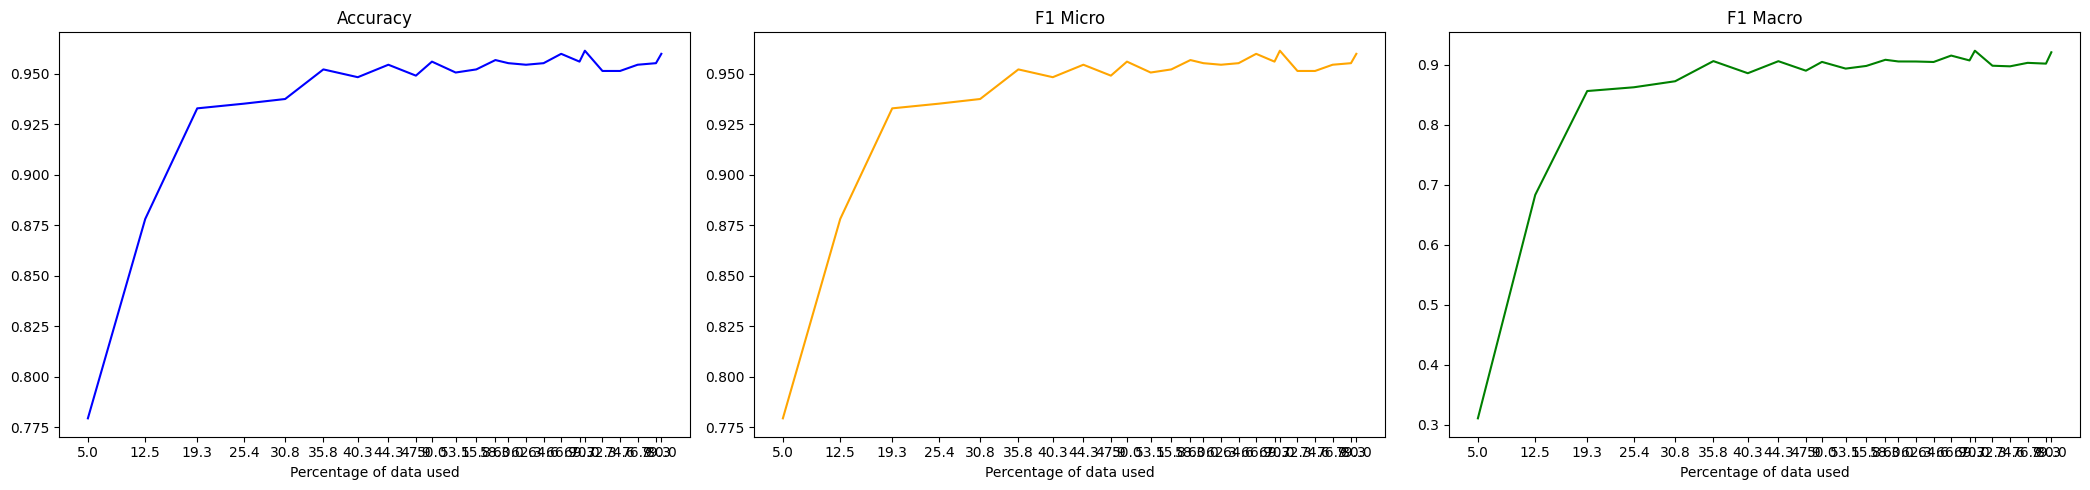

In [22]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.647, Accuracy: 0.7054, F1 Micro: 0.8127, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5731, Accuracy: 0.7374, F1 Micro: 0.8408, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5493, Accuracy: 0.7917, F1 Micro: 0.8824, F1 Macro: 0.8802
Epoch 4/10, Train Loss: 0.5049, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Epoch 5/10, Train Loss: 0.4781, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 6/10, Train Loss: 0.4364, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4061, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 8/10, Train Loss: 0.4421, Accuracy: 0.7902, F1 Micro: 0.8825, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4208, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6351, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5577, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5004, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4905, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4593, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4341, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4188, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2323, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6166, Accuracy: 0.7932, F1 Micro: 0.8809, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5082, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4748, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4337, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4136, Accuracy: 0.8088, F1 Micro: 0.8916, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3808, Accuracy: 0.8504, F1 Micro: 0.9127, F1 Macro: 0.912
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3411, Accuracy: 0.8653, F1 Micro: 0.9197, F1 Macro: 0.9186
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3042, Accuracy: 0.8705, F1 Micro: 0.9211, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6443, Accuracy: 0.7233, F1 Micro: 0.7233, F1 Macro: 0.4197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5386, Accuracy: 0.7233, F1 Micro: 0.7233, F1 Macro: 0.4197
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4883, Accuracy: 0.7621, F1 Micro: 0.7621, F1 Macro: 0.5633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3803, Accuracy: 0.8155, F1 Micro: 0.8155, F1 Macro: 0.7556
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2456, Accuracy: 0.8592, F1 Micro: 0.8592, F1 Macro: 0.8319
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1724, Accuracy: 0.8786, F1 Micro: 0.8786, F1 Macro: 0.8476
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.8786, F1 Micro: 0.8786, F1 Macro: 0.8523
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.8786, F1 Micro: 0.8786, F1 Macro: 0.8589
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.581, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Epoch 2/10, Train Loss: 0.5054, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4739, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4441, Accuracy: 0.8281, F1 Micro: 0.9012, F1 Macro: 0.9003
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3974, Accuracy: 0.846, F1 Micro: 0.9096, F1 Macro: 0.9079
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3341, Accuracy: 0.8765, F1 Micro: 0.9249, F1 Macro: 0.9225
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2872, Accuracy: 0.8988, F1 Micro: 0.9378, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2551, Accuracy: 0.9107, F1 Micro: 0.9443, F1 Macro: 0.9422
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2138, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.605, Accuracy: 0.7066, F1 Micro: 0.7066, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5296, Accuracy: 0.8108, F1 Micro: 0.8108, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3167, Accuracy: 0.8687, F1 Micro: 0.8687, F1 Macro: 0.8483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.906
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8917
Epoch 6/10, Train Loss: 0.1468, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9025
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9031
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9031
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8909
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8943

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5834, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5119, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4582, Accuracy: 0.8118, F1 Micro: 0.8935, F1 Macro: 0.8923
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4057, Accuracy: 0.872, F1 Micro: 0.9243, F1 Macro: 0.9235
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3237, Accuracy: 0.9085, F1 Micro: 0.9438, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2812, Accuracy: 0.9308, F1 Micro: 0.9569, F1 Macro: 0.9553
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2232, Accuracy: 0.9427, F1 Micro: 0.9642, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1758, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6247, Accuracy: 0.685, F1 Micro: 0.685, F1 Macro: 0.4065
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4431, Accuracy: 0.8031, F1 Micro: 0.8031, F1 Macro: 0.7272
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2367, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2068, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9293
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9204
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.919
Epoch 7/10, Train Loss: 0.0941, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9116
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9222
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9242
Epoch 10/10, Train Loss: 0.084, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.913

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5586, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4848, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4418, Accuracy: 0.8326, F1 Micro: 0.904, F1 Macro: 0.9034
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.36, Accuracy: 0.9167, F1 Micro: 0.9485, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2823, Accuracy: 0.9323, F1 Micro: 0.958, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2386, Accuracy: 0.9449, F1 Micro: 0.9657, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1836, Accuracy: 0.9479, F1 Micro: 0.9673, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1455, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.585, Accuracy: 0.6797, F1 Micro: 0.6797, F1 Macro: 0.4047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4626, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2345, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9262
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9139
Epoch 5/10, Train Loss: 0.1605, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9216
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9203
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9171
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9161
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8984
Epoch 10/10, Train Loss: 0.0515, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.9007

Sentiment analysis accuracy: 0.9336, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5507, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7954, F1 Micro: 0.8852, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4316, Accuracy: 0.8921, F1 Micro: 0.9354, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.312, Accuracy: 0.9182, F1 Micro: 0.9486, F1 Macro: 0.9444
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2423, Accuracy: 0.9412, F1 Micro: 0.9632, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1867, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1479, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9723
Epoch 8/10, Train Loss: 0.1192, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0959, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5826, Accuracy: 0.6733, F1 Micro: 0.6733, F1 Macro: 0.4138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3709, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1716, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9335
Epoch 4/10, Train Loss: 0.1332, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.081, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9335
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9242
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9074
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8876
Epoch 9/10, Train Loss: 0.0896, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.928
Epoch 10/10, Train Loss: 0.0482, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9153

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5566, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4935, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3923, Accuracy: 0.9115, F1 Micro: 0.9461, F1 Macro: 0.9442
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2974, Accuracy: 0.9375, F1 Micro: 0.9612, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2296, Accuracy: 0.9427, F1 Micro: 0.9643, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1727, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1413, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.1087, Accuracy: 0.9494, F1 Micro: 0.968, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0933, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5326, Accuracy: 0.7231, F1 Micro: 0.7231, F1 Macro: 0.5325
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2754, Accuracy: 0.8846, F1 Micro: 0.8846, F1 Macro: 0.8767
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1361, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0999, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9177
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0762, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9186
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9227
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8985
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5421, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.473, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3941, Accuracy: 0.9129, F1 Micro: 0.9464, F1 Macro: 0.9446
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2778, Accuracy: 0.9427, F1 Micro: 0.9646, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2202, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1736, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9712
Epoch 7/10, Train Loss: 0.1304, Accuracy: 0.9472, F1 Micro: 0.9664, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.087, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5354, Accuracy: 0.6692, F1 Micro: 0.6692, F1 Macro: 0.4009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3772, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9402
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9324
Epoch 4/10, Train Loss: 0.1201, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9276
Epoch 5/10, Train Loss: 0.0756, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9276
Epoch 6/10, Train Loss: 0.0748, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9199
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9218
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9177
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9177
Epoch 10/10, Train Loss: 0.0604, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9264

Sentiment analysis accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9402
           

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5449, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4613, Accuracy: 0.8393, F1 Micro: 0.9075, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3505, Accuracy: 0.9189, F1 Micro: 0.9496, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2575, Accuracy: 0.9435, F1 Micro: 0.965, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1931, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1448, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9732
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0726, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5098, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.289, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.9477
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9081
Epoch 4/10, Train Loss: 0.1106, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8967
Epoch 5/10, Train Loss: 0.109, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9229
Epoch 6/10, Train Loss: 0.1394, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.9002
Epoch 7/10, Train Loss: 0.1266, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9152
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9122
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9188
Epoch 10/10, Train Loss: 0.0574, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9046

Sentiment analysis accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.9477
              precisi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5513, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4755, Accuracy: 0.8296, F1 Micro: 0.9023, F1 Macro: 0.9015
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3502, Accuracy: 0.907, F1 Micro: 0.9416, F1 Macro: 0.9381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2615, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1969, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1162, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0716, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5534, Accuracy: 0.877, F1 Micro: 0.877, F1 Macro: 0.8545
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2923, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9425
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1325, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9431
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9382
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9386
Epoch 7/10, Train Loss: 0.0957, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9252
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9136
Epoch 9/10, Train Loss: 0.1027, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9222
Epoch 10/10, Train Loss: 0.0636, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.926

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5398, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4405, Accuracy: 0.8475, F1 Micro: 0.9116, F1 Macro: 0.9108
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3345, Accuracy: 0.9308, F1 Micro: 0.957, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2446, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1824, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.523, Accuracy: 0.8697, F1 Micro: 0.8697, F1 Macro: 0.8468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2428, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8924
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1892, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.931
Epoch 4/10, Train Loss: 0.1141, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9229
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9188
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9156
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9277
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9201
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9156
Epoch 10/10, Train Loss: 0.0655, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9037

Sentiment analysis accuracy: 0.9387, F1 Micro: 0.9387

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5388, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4432, Accuracy: 0.8802, F1 Micro: 0.9293, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3165, Accuracy: 0.9397, F1 Micro: 0.9624, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.223, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1713, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5475, Accuracy: 0.7854, F1 Micro: 0.7854, F1 Macro: 0.697
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2543, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1731, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9192
Epoch 4/10, Train Loss: 0.1267, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9161
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9224
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9269
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8994
Epoch 10/10, Train Loss: 0.0775, Accuracy: 0.9234, F1 Micro: 0.9234, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.536, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4399, Accuracy: 0.8847, F1 Micro: 0.9313, F1 Macro: 0.9304
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3102, Accuracy: 0.9412, F1 Micro: 0.9635, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2216, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1658, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0966, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0676, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5431, Accuracy: 0.8061, F1 Micro: 0.8061, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2563, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9255
Epoch 3/10, Train Loss: 0.1539, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9129
Epoch 4/10, Train Loss: 0.1082, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.92
Epoch 5/10, Train Loss: 0.1033, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9208
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9164
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.916
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.912
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9116
Epoch 10/10, Train Loss: 0.0475, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.916

Sentiment analysis accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9255
              precisi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.542, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4236, Accuracy: 0.9003, F1 Micro: 0.9399, F1 Macro: 0.9386
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3009, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2051, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.155, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9738
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9583, F1 Micro: 0.9736, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 8/10, Train Loss: 0.0771, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9732
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5345, Accuracy: 0.8301, F1 Micro: 0.8301, F1 Macro: 0.7847
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2851, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1521, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9295
Epoch 4/10, Train Loss: 0.1455, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9139
Epoch 5/10, Train Loss: 0.1052, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Epoch 7/10, Train Loss: 0.0509, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9225
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.9305, F1 Micro: 0.9305, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5233, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4149, Accuracy: 0.9092, F1 Micro: 0.945, F1 Macro: 0.9432
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2882, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2097, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5157, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2494, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9434
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9343
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9392
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0825, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9428
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5256, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4153, Accuracy: 0.8996, F1 Micro: 0.9382, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2861, Accuracy: 0.9412, F1 Micro: 0.9633, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2053, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1539, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9745
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9658, F1 Micro: 0.9784, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5578, Accuracy: 0.8621, F1 Micro: 0.8621, F1 Macro: 0.8342
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2501, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9233
Epoch 3/10, Train Loss: 0.1923, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9121
Epoch 4/10, Train Loss: 0.1278, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9006
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8987
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9125
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9165
Epoch 8/10, Train Loss: 0.0979, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9046
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.09, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0841, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9277

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.531, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4076, Accuracy: 0.9085, F1 Micro: 0.9437, F1 Macro: 0.9417
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2823, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9781
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4949, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9297
Epoch 2/10, Train Loss: 0.2367, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8945
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9238
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1181, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9388
Epoch 5/10, Train Loss: 0.1065, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9437
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0934, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0488, Accuracy:

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5252, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4019, Accuracy: 0.9167, F1 Micro: 0.9481, F1 Macro: 0.9452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.274, Accuracy: 0.9494, F1 Micro: 0.9687, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9591, F1 Micro: 0.9746, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5008, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8947
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2246, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1729, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1289, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9359
Epoch 5/10, Train Loss: 0.1365, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9397
Epoch 7/10, Train Loss: 0.0921, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9435
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9393
Epoch 10/10, Train Loss: 0.0424, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5278, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3995, Accuracy: 0.9226, F1 Micro: 0.9522, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2631, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9479, F1 Micro: 0.9669, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9673, F1 Micro: 0.9792, F1 Macro: 0.9776
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4982, Accuracy: 0.8962, F1 Micro: 0.8962, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9163
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1205, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9276
Epoch 5/10, Train Loss: 0.0995, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1015, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9392
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9243
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9157
Epoch 10/10, Train Loss: 0.0594, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5297, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.371, Accuracy: 0.9293, F1 Micro: 0.956, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2477, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.979
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9695, F1 Micro: 0.9807, F1 Macro: 0.9795
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4927, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8991
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1946, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1654, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9323
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1021, Accuracy: 0.9515, F1 Micro: 0.9515, F1 Macro: 0.9449
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8978
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9251
Epoch 10/10, Train Loss: 0.0528, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.523, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3851, Accuracy: 0.9256, F1 Micro: 0.9539, F1 Macro: 0.9517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2605, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9801
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.979
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9665, F1 Micro: 0.9787, F1 Macro: 0.9763
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5123, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9118
Epoch 2/10, Train Loss: 0.2306, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.9057
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9158
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1248, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9279
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9442
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9088
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.9019
Epoch 10/10, Train Loss: 0.0638, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5194, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3753, Accuracy: 0.9226, F1 Micro: 0.9518, F1 Macro: 0.9493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2556, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9759
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5286, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2742, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9297
Epoch 3/10, Train Loss: 0.1398, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.9003
Epoch 4/10, Train Loss: 0.1147, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8992
Epoch 5/10, Train Loss: 0.0985, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9254
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9377
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9281
Epoch 9/10, Train Loss: 0.0663, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9294
Epoch 10/10, Train Loss: 0.0621, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9333

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5214, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3655, Accuracy: 0.9382, F1 Micro: 0.962, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.224, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9742
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macro: 0.9816
Epoch 10/10, Train Loss: 0.0435, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4441, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2136, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9444
Epoch 3/10, Train Loss: 0.1562, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9306
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9243
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9284
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8974
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.9485
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9199
Epoch 10/10, Train Loss: 0.0554, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9351

Sentiment analysis accuracy: 0.9535, F1 Micro: 0.9535, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5219, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3784, Accuracy: 0.9353, F1 Micro: 0.9598, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2428, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9783
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Higher F1 achieved, saving m

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5414, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8955
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.278, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9364
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.925
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9451
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9408
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9246
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.937
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9411
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.937

Sentiment analysis acc

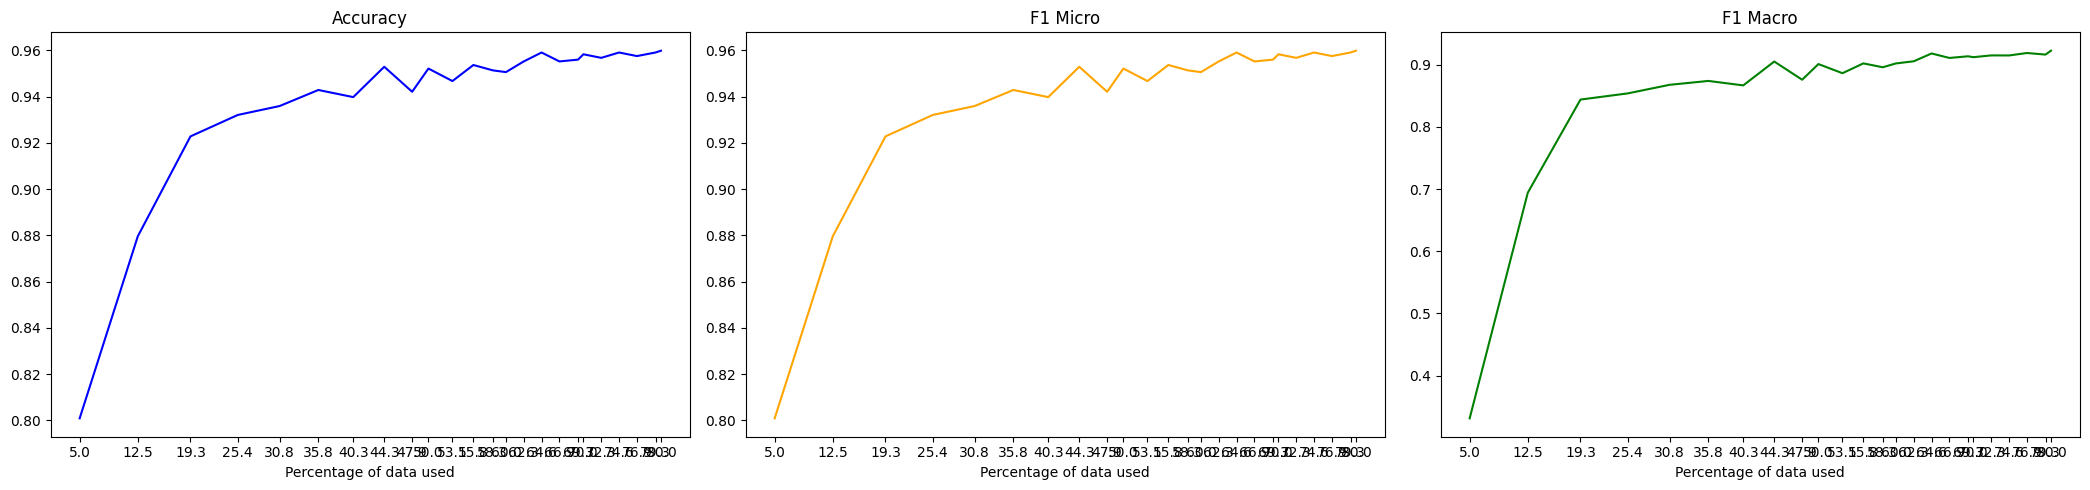

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6791, Accuracy: 0.7746, F1 Micro: 0.8722, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5752, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.512, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4609, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4635, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4127, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3898, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4151, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.8159, Accuracy: 0.3333, F1 Micro: 0.3333, F1 Macro: 0.25
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6264, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5442, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5154, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4038, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3617, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3192, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2942, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3391, Accuracy: 0.66

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6276, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5185, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4802, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.442, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4615, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4061, Accuracy: 0.8006, F1 Micro: 0.8878, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3639, Accuracy: 0.8222, F1 Micro: 0.898, F1 Macro: 0.8963
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3379, Accuracy: 0.8452, F1 Micro: 0.9096, F1 Macro: 0.9078
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7006, Accuracy: 0.6488, F1 Micro: 0.6488, F1 Macro: 0.3935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6185, Accuracy: 0.6488, F1 Micro: 0.6488, F1 Macro: 0.3935
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5476, Accuracy: 0.7798, F1 Micro: 0.7798, F1 Macro: 0.7131
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4489, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.8607
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3309, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2432, Accuracy: 0.9643, F1 Micro: 0.9643, F1 Macro: 0.9614
Epoch 7/10, Train Loss: 0.1869, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9395
Epoch 8/10, Train Loss: 0.1383, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.941
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9583, F1 Micro: 0.9583, F1 Macro: 0.9545
Epoch 10/10, Train Loss: 0.037, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5934, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5012, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4962, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.446, Accuracy: 0.7946, F1 Micro: 0.8848, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4009, Accuracy: 0.8266, F1 Micro: 0.9, F1 Macro: 0.8985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3493, Accuracy: 0.8743, F1 Micro: 0.9252, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3067, Accuracy: 0.9092, F1 Micro: 0.9447, F1 Macro: 0.9429
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2599, Accuracy: 0.9226, F1 Micro: 0.9525, F1 Macro: 0.9505
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6588, Accuracy: 0.6359, F1 Micro: 0.6359, F1 Macro: 0.3887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5727, Accuracy: 0.6359, F1 Micro: 0.6359, F1 Macro: 0.3887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5017, Accuracy: 0.7718, F1 Micro: 0.7718, F1 Macro: 0.6996
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3436, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2463, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9262
Epoch 6/10, Train Loss: 0.2839, Accuracy: 0.9223, F1 Micro: 0.9223, F1 Macro: 0.9186
Epoch 7/10, Train Loss: 0.1581, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9197
Epoch 8/10, Train Loss: 0.1279, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9228
Epoch 9/10, Train Loss: 0.0867, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.103, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5778, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5095, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.479, Accuracy: 0.7946, F1 Micro: 0.8848, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4182, Accuracy: 0.8467, F1 Micro: 0.9103, F1 Macro: 0.9082
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3449, Accuracy: 0.8981, F1 Micro: 0.9387, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2846, Accuracy: 0.9234, F1 Micro: 0.9527, F1 Macro: 0.9506
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2394, Accuracy: 0.9405, F1 Micro: 0.9632, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1872, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9655
Epoch 9/10, Train Loss: 0.1551, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5763, Accuracy: 0.6778, F1 Micro: 0.6778, F1 Macro: 0.404
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4194, Accuracy: 0.8787, F1 Micro: 0.8787, F1 Macro: 0.8503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2437, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.935
Epoch 4/10, Train Loss: 0.2024, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8976
Epoch 5/10, Train Loss: 0.1777, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9234
Epoch 6/10, Train Loss: 0.1809, Accuracy: 0.9372, F1 Micro: 0.9372, F1 Macro: 0.9302
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9244
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9228
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9247, F1 Micro: 0.9247, F1 Macro: 0.9138
Epoch 10/10, Train Loss: 0.0727, Accuracy: 0.9372, F1 Micro: 0.9372, F1 Macro: 0.9289

Sentiment analysis accuracy: 0.9414, F1 Micro: 0.94

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.578, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4867, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4416, Accuracy: 0.8065, F1 Micro: 0.889, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3742, Accuracy: 0.8839, F1 Micro: 0.9307, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3069, Accuracy: 0.9249, F1 Micro: 0.9538, F1 Macro: 0.9519
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2436, Accuracy: 0.942, F1 Micro: 0.9641, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1965, Accuracy: 0.9449, F1 Micro: 0.9659, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1459, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9691
Epoch 9/10, Train Loss: 0.1188, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6333, Accuracy: 0.6778, F1 Micro: 0.6778, F1 Macro: 0.404
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4358, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2351, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1638, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9248
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9209
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9209
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9247, F1 Micro: 0.9247, F1 Macro: 0.9169
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9177
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0713, Accuracy: 0.9414, F1 Micro: 0.9414, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.558, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4919, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4163, Accuracy: 0.8423, F1 Micro: 0.9085, F1 Macro: 0.9069
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3375, Accuracy: 0.9196, F1 Micro: 0.951, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2612, Accuracy: 0.9457, F1 Micro: 0.9664, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1913, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1452, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9698
Epoch 8/10, Train Loss: 0.1176, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1012, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5784, Accuracy: 0.8242, F1 Micro: 0.8242, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3906, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8984
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9295
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9129
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9127
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1065, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.938
Epoch 10/10, Train Loss: 0.0724, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5628, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4684, Accuracy: 0.7946, F1 Micro: 0.8848, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4042, Accuracy: 0.8713, F1 Micro: 0.9239, F1 Macro: 0.9222
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.317, Accuracy: 0.9256, F1 Micro: 0.9544, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2414, Accuracy: 0.9427, F1 Micro: 0.9644, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1824, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1376, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9719
Epoch 8/10, Train Loss: 0.1191, Accuracy: 0.9561, F1 Micro: 0.9723, F1 Macro: 0.9705
Epoch 9/10, Train Loss: 0.0933, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5547, Accuracy: 0.7588, F1 Micro: 0.7588, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.313, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9136
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1594, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9297
Epoch 4/10, Train Loss: 0.1351, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9347
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9181
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9163
Epoch 8/10, Train Loss: 0.1065, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9116
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9264
Epoch 10/10, Train Loss: 0.0687, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9255

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5548, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4809, Accuracy: 0.7991, F1 Micro: 0.8866, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3977, Accuracy: 0.8824, F1 Micro: 0.9303, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3027, Accuracy: 0.9405, F1 Micro: 0.9632, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2247, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1652, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.1325, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9739
Epoch 8/10, Train Loss: 0.1092, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9722
Epoch 9/10, Train Loss: 0.0884, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9716
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.552, Accuracy: 0.814, F1 Micro: 0.814, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2882, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9453
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9628, F1 Micro: 0.9628, F1 Macro: 0.9586
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9325
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9497
Epoch 7/10, Train Loss: 0.1099, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9494
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.9587, F1 Micro: 0.9587, F1 Macro: 0.9542
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9587, F1 Micro: 0.9587, F1 Macro: 0.9539
Epoch 10/10, Train Loss: 0.0549, Accuracy: 0.9587, F1 Micro: 0.9587, F1 Macro: 0.9539

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5548, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4611, Accuracy: 0.8058, F1 Micro: 0.8902, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3625, Accuracy: 0.9107, F1 Micro: 0.945, F1 Macro: 0.9424
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2704, Accuracy: 0.9457, F1 Micro: 0.9665, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1945, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1404, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.1109, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9738
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9756
Epoch 10/10, Train Loss: 0.0629, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5816, Accuracy: 0.7683, F1 Micro: 0.7683, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3227, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro: 0.92
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.9124
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.9309, F1 Micro: 0.9309, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9455
Epoch 6/10, Train Loss: 0.0686, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9411
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9404
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0429, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9553, F1 Micro: 0.9553, F1 Macro: 0.9504
Epoch 10/10, Train Loss: 0.0571, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5377, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4671, Accuracy: 0.8058, F1 Micro: 0.8903, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3678, Accuracy: 0.9241, F1 Micro: 0.9535, F1 Macro: 0.9519
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2679, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2015, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1499, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.975
Epoch 7/10, Train Loss: 0.1136, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9628, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5175, Accuracy: 0.8706, F1 Micro: 0.8706, F1 Macro: 0.8397
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2654, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9231
Epoch 3/10, Train Loss: 0.1732, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.919
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1171, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9471
Epoch 8/10, Train Loss: 0.1082, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9186
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5472, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4672, Accuracy: 0.8207, F1 Micro: 0.8963, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3572, Accuracy: 0.9234, F1 Micro: 0.9529, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2446, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1815, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9737
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9561, F1 Micro: 0.9723, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5404, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.8732
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9358
Epoch 3/10, Train Loss: 0.1411, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9265
Epoch 4/10, Train Loss: 0.108, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9574, F1 Micro: 0.9574, F1 Macro: 0.9524
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9336
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9348
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9196
Epoch 10/10, Train Loss: 0.0779, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9236

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5345, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4453, Accuracy: 0.8527, F1 Micro: 0.914, F1 Macro: 0.9124
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3269, Accuracy: 0.9293, F1 Micro: 0.9566, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2348, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1667, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1245, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.068, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5221, Accuracy: 0.8731, F1 Micro: 0.8731, F1 Macro: 0.8535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2827, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9259
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9309
Epoch 4/10, Train Loss: 0.1318, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9235
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.943
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9361
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9405
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9615, F1 Micro: 0.9615, F1 Macro: 0.9571
Epoch 10/10, Train Loss: 0.0449, Accuracy: 0.9577, F1 Micro: 0.9577, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5475, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4522, Accuracy: 0.8467, F1 Micro: 0.9103, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3202, Accuracy: 0.9308, F1 Micro: 0.9575, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2303, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1669, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.0666, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5215, Accuracy: 0.8492, F1 Micro: 0.8492, F1 Macro: 0.8121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9222
Epoch 3/10, Train Loss: 0.1796, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1206, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9386
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9107
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0913, Accuracy: 0.9603, F1 Micro: 0.9603, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9603, F1 Micro: 0.9603, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9603, F1 Micro: 0.9603, F1 Macro: 0.9563
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5328, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.435, Accuracy: 0.8795, F1 Micro: 0.9282, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.294, Accuracy: 0.9442, F1 Micro: 0.9655, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2022, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0932, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0616, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5236, Accuracy: 0.8864, F1 Micro: 0.8864, F1 Macro: 0.8729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2773, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9363
Epoch 3/10, Train Loss: 0.1653, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9322
Epoch 4/10, Train Loss: 0.1321, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9329
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9444
Epoch 10/10, Train Loss: 0.0494, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5301, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4316, Accuracy: 0.8817, F1 Micro: 0.9287, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2993, Accuracy: 0.9449, F1 Micro: 0.9659, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2026, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.975
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4761, Accuracy: 0.8855, F1 Micro: 0.8855, F1 Macro: 0.875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2566, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.923
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1252, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.937
Epoch 5/10, Train Loss: 0.1029, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9319
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9448
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9448
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9162
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5257, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4286, Accuracy: 0.8996, F1 Micro: 0.9387, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2958, Accuracy: 0.9449, F1 Micro: 0.9659, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1992, Accuracy: 0.9591, F1 Micro: 0.9746, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1206, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.0895, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9736
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4964, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9166
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2231, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1939, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9565, F1 Micro: 0.9565, F1 Macro: 0.9517
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.933
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.908
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9278
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.9334
Epoch 9/10, Train Loss: 0.1035, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8888
Epoch 10/10, Train Loss: 0.0823, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9423

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5343, Accuracy: 0.7969, F1 Micro: 0.8858, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4144, Accuracy: 0.9033, F1 Micro: 0.9415, F1 Macro: 0.9398
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2821, Accuracy: 0.9457, F1 Micro: 0.9665, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.194, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5267, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3007, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2194, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9433
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9286
Epoch 5/10, Train Loss: 0.0942, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9465
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9349
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9371
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9341
Epoch 10/10, Train Loss: 0.0591, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9391

Sentiment analys

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.52, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4135, Accuracy: 0.907, F1 Micro: 0.9436, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2724, Accuracy: 0.9501, F1 Micro: 0.9692, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1387, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9752
Epoch 10/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5028, Accuracy: 0.891, F1 Micro: 0.891, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2319, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
Epoch 4/10, Train Loss: 0.1245, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9061
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.924
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9169
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9317
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9209
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8975
Epoch 10/10, Train Loss: 0.0414, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9151

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5288, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4139, Accuracy: 0.9077, F1 Micro: 0.944, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2715, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1949, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9743
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9731
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5346, Accuracy: 0.8817, F1 Micro: 0.8817, F1 Macro: 0.8711
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2334, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9445
Epoch 3/10, Train Loss: 0.1628, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9286
Epoch 4/10, Train Loss: 0.1321, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9308
Epoch 5/10, Train Loss: 0.1085, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9127
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9202
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.919
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9242
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0608, Accuracy: 0.958, F1 Micro: 0.958, F1 Macro: 0.9525

Sentiment analysis accuracy: 0.958, F1 Micro: 0.958,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5215, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4077, Accuracy: 0.9048, F1 Micro: 0.9419, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.264, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4874, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9219
Epoch 2/10, Train Loss: 0.234, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1228, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9386
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9337
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0549, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9426
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9337
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9344
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9299
Epoch 10/10, Train Loss: 0.0509, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.924

Sentiment analysis accuracy: 0.948, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5193, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4005, Accuracy: 0.9189, F1 Micro: 0.9504, F1 Macro: 0.9487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2616, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9673, F1 Micro: 0.9796, F1 Macro: 0.9784
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9733
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9734
Epoch 10/10, Train Loss: 0.0459, Accuracy: 0.9643, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5236, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.9029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.9306, F1 Micro: 0.9306, F1 Macro: 0.9248
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8923
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1513, Accuracy: 0.9551, F1 Micro: 0.9551, F1 Macro: 0.9509
Epoch 5/10, Train Loss: 0.1036, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.9362
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.951, F1 Micro: 0.951, F1 Macro: 0.9457
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.951, F1 Micro: 0.951, F1 Macro: 0.9457
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9551, F1 Micro: 0.9551, F1 Macro: 0.9503
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9206
Epoch 10/10, Train Loss: 0.0495, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.9369

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5274, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3973, Accuracy: 0.9234, F1 Micro: 0.9529, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2493, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4839, Accuracy: 0.8726, F1 Micro: 0.8726, F1 Macro: 0.8663
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2384, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2017, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9285
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9165
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9398
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5286, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3888, Accuracy: 0.9174, F1 Micro: 0.9489, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2459, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9788
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5007, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.937
Epoch 2/10, Train Loss: 0.205, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9105
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1308, Accuracy: 0.9513, F1 Micro: 0.9513, F1 Macro: 0.9454
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9337
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9513, F1 Micro: 0.9513, F1 Macro: 0.9448
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9513, F1 Micro: 0.9513, F1 Macro: 0.9448
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.933
Epoch 9/10, Train Loss: 0.0676, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9337
Epoch 10/10, Train Loss: 0.0586, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9278

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.389, Accuracy: 0.9263, F1 Micro: 0.9545, F1 Macro: 0.9525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2445, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9771
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4914, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2481, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1678, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9404
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9448
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9542, F1 Micro: 0.9542, F1 Macro: 0.949
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.918
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9401
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.9542, F1 Micro: 0.9542, F1 Macro: 0.9481
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9167
Epoch 10/10, Train Loss: 0.0489, Accura

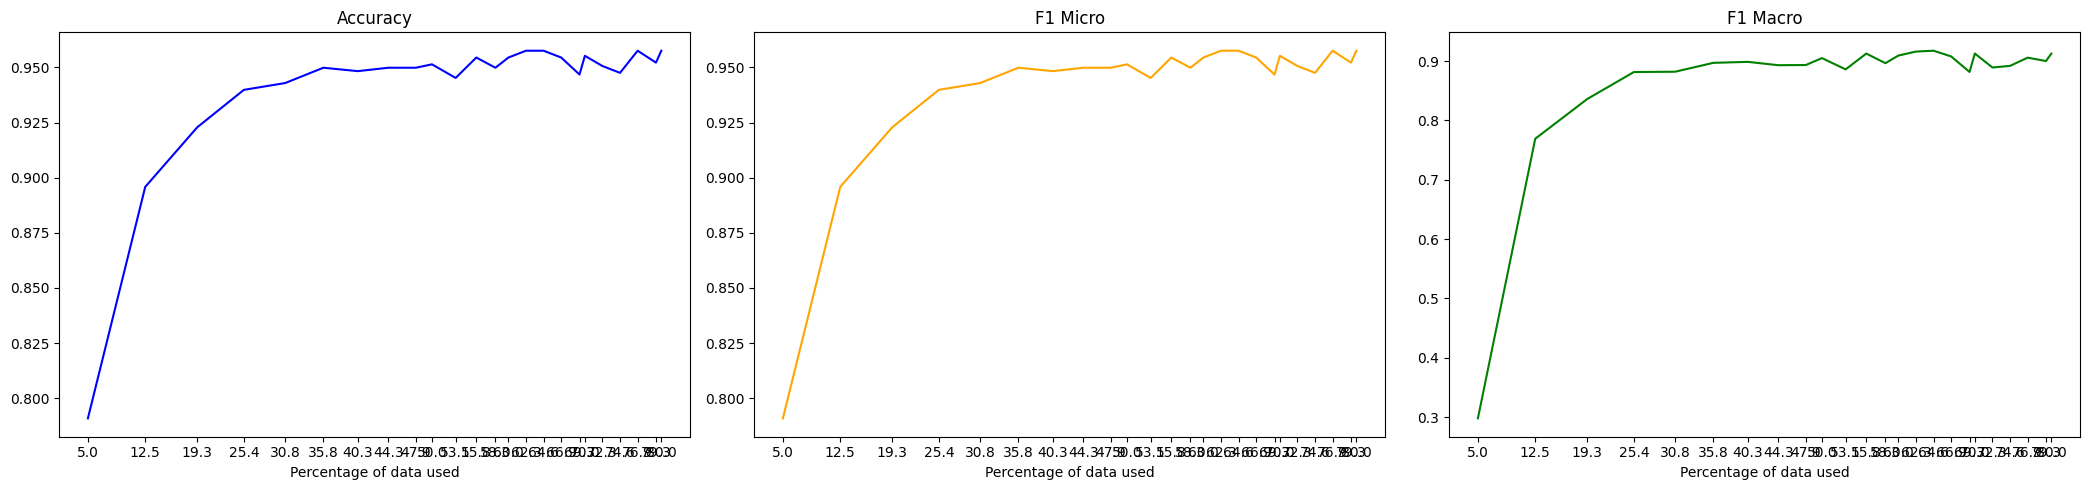

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6456, Accuracy: 0.7865, F1 Micro: 0.8804, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5639, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5346, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5259, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4788, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 6/10, Train Loss: 0.477, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.4707, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4588, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4215, Accuracy: 0.7932, F1 Micro: 0.8839, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7056, Accuracy: 0.44, F1 Micro: 0.44, F1 Macro: 0.4318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5997, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5241, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5185, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.494, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4806, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4617, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.422, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3873, Accuracy: 0.84, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5994, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5168, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 3/10, Train Loss: 0.4623, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4885, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4675, Accuracy: 0.7969, F1 Micro: 0.8857, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4343, Accuracy: 0.8051, F1 Micro: 0.8895, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3938, Accuracy: 0.8229, F1 Micro: 0.8985, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3204, Accuracy: 0.8594, F1 Micro: 0.9168, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2984, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.615, Accuracy: 0.6957, F1 Micro: 0.6957, F1 Macro: 0.4103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4892, Accuracy: 0.6957, F1 Micro: 0.6957, F1 Macro: 0.4103
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4518, Accuracy: 0.7011, F1 Micro: 0.7011, F1 Macro: 0.4291
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3441, Accuracy: 0.8315, F1 Micro: 0.8315, F1 Macro: 0.7934
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2647, Accuracy: 0.8587, F1 Micro: 0.8587, F1 Macro: 0.8331
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1425, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1434, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8983
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8903
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8762
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5805, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5032, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.5106, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4625, Accuracy: 0.7932, F1 Micro: 0.884, F1 Macro: 0.8824
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4175, Accuracy: 0.8155, F1 Micro: 0.8943, F1 Macro: 0.8925
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3633, Accuracy: 0.8504, F1 Micro: 0.9123, F1 Macro: 0.9106
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3074, Accuracy: 0.8988, F1 Micro: 0.9387, F1 Macro: 0.9365
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2578, Accuracy: 0.9167, F1 Micro: 0.9482, F1 Macro: 0.9457
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2048, Accuracy: 0.9263, F1 Micro: 0.9547, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6504, Accuracy: 0.6739, F1 Micro: 0.6739, F1 Macro: 0.4026
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5423, Accuracy: 0.8087, F1 Micro: 0.8087, F1 Macro: 0.7404
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3415, Accuracy: 0.8739, F1 Micro: 0.8739, F1 Macro: 0.8622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2301, Accuracy: 0.9304, F1 Micro: 0.9304, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1093, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.941
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.9348, F1 Micro: 0.9348, F1 Macro: 0.927
Epoch 7/10, Train Loss: 0.0537, Accuracy: 0.9391, F1 Micro: 0.9391, F1 Macro: 0.9321
Epoch 8/10, Train Loss: 0.1, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0.9087
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.9036
Epoch 10/10, Train Loss: 0.0602, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5672, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.5043, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4661, Accuracy: 0.7917, F1 Micro: 0.8833, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4385, Accuracy: 0.811, F1 Micro: 0.8923, F1 Macro: 0.8908
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3611, Accuracy: 0.8661, F1 Micro: 0.9208, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3035, Accuracy: 0.9167, F1 Micro: 0.9483, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2356, Accuracy: 0.9368, F1 Micro: 0.961, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.184, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1577, Accuracy: 0.9546, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6275, Accuracy: 0.6582, F1 Micro: 0.6582, F1 Macro: 0.4085
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.482, Accuracy: 0.8861, F1 Micro: 0.8861, F1 Macro: 0.8669
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2489, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.945
Epoch 4/10, Train Loss: 0.1972, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9399
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9241, F1 Micro: 0.9241, F1 Macro: 0.9134
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9536, F1 Micro: 0.9536, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9578, F1 Micro: 0.9578, F1 Macro: 0.9539
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9536, F1 Micro: 0.9536, F1 Macro: 0.9494
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9536, F1 Micro: 0.9536, F1 Macro: 0.9494
Epoch 10/10, Train Loss: 0.0637, Accuracy: 0.9494, F1 Micro: 0.9494, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5566, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.509, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4567, Accuracy: 0.7961, F1 Micro: 0.8854, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4059, Accuracy: 0.8676, F1 Micro: 0.9215, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3181, Accuracy: 0.9211, F1 Micro: 0.9518, F1 Macro: 0.95
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2534, Accuracy: 0.9442, F1 Micro: 0.9655, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1902, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1414, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9715
Epoch 9/10, Train Loss: 0.1235, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9709
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6073, Accuracy: 0.6708, F1 Micro: 0.6708, F1 Macro: 0.4015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3842, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.241, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.9294
Epoch 4/10, Train Loss: 0.1203, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1084, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9404
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.9308
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9451
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9451
Epoch 10/10, Train Loss: 0.0414, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5483, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4872, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4333, Accuracy: 0.8185, F1 Micro: 0.8963, F1 Macro: 0.8949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3477, Accuracy: 0.907, F1 Micro: 0.9432, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2695, Accuracy: 0.9412, F1 Micro: 0.9637, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2005, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9693
Epoch 7/10, Train Loss: 0.1511, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9688
Epoch 8/10, Train Loss: 0.1204, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1015, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5977, Accuracy: 0.6857, F1 Micro: 0.6857, F1 Macro: 0.4306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4256, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2466, Accuracy: 0.951, F1 Micro: 0.951, F1 Macro: 0.9432
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.9332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9551, F1 Micro: 0.9551, F1 Macro: 0.9481
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macro: 0.9151
Epoch 7/10, Train Loss: 0.1254, Accuracy: 0.9469, F1 Micro: 0.9469, F1 Macro: 0.9387
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9429, F1 Micro: 0.9429, F1 Macro: 0.9362
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.951, F1 Micro: 0.951, F1 Macro: 0.944
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.951, F1 Micro: 0.951, F1 Macro: 0.944

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.535, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4731, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4147, Accuracy: 0.8609, F1 Micro: 0.918, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3168, Accuracy: 0.9196, F1 Micro: 0.9505, F1 Macro: 0.9489
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2438, Accuracy: 0.9442, F1 Micro: 0.9656, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1767, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1377, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.1181, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0893, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5704, Accuracy: 0.753, F1 Micro: 0.753, F1 Macro: 0.6259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.327, Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.9502
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9159
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9412
Epoch 5/10, Train Loss: 0.1443, Accuracy: 0.9271, F1 Micro: 0.9271, F1 Macro: 0.9202
Epoch 6/10, Train Loss: 0.077, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9217
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9555, F1 Micro: 0.9555, F1 Macro: 0.9502
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9309
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.926
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9325

Sentiment analysis accuracy: 0.9555, F1 Micro: 0.9555,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5389, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4804, Accuracy: 0.7954, F1 Micro: 0.8852, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4285, Accuracy: 0.849, F1 Micro: 0.9116, F1 Macro: 0.91
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3264, Accuracy: 0.9308, F1 Micro: 0.9574, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2434, Accuracy: 0.9405, F1 Micro: 0.9631, F1 Macro: 0.9614
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1768, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1431, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.1117, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9716
Epoch 9/10, Train Loss: 0.0916, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5699, Accuracy: 0.8112, F1 Micro: 0.8112, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3075, Accuracy: 0.9399, F1 Micro: 0.9399, F1 Macro: 0.9325
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.9399, F1 Micro: 0.9399, F1 Macro: 0.933
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1441, Accuracy: 0.9614, F1 Micro: 0.9614, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.098, Accuracy: 0.9657, F1 Micro: 0.9657, F1 Macro: 0.9626
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9485, F1 Micro: 0.9485, F1 Macro: 0.9429
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9614, F1 Micro: 0.9614, F1 Macro: 0.9578
Epoch 8/10, Train Loss: 0.0815, Accuracy: 0.9571, F1 Micro: 0.9571, F1 Macro: 0.953
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9571, F1 Micro: 0.9571, F1 Macro: 0.953
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5364, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4734, Accuracy: 0.7984, F1 Micro: 0.8866, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3811, Accuracy: 0.9018, F1 Micro: 0.9409, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2716, Accuracy: 0.939, F1 Micro: 0.9625, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.189, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.143, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1118, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5894, Accuracy: 0.6953, F1 Micro: 0.6953, F1 Macro: 0.4918
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3592, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1832, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9436
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9436
Epoch 6/10, Train Loss: 0.0824, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9397
Epoch 7/10, Train Loss: 0.0856, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9192
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9391
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9245
Epoch 10/10, Train Loss: 0.0587, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9291

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5333, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4678, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3943, Accuracy: 0.8981, F1 Micro: 0.9385, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2737, Accuracy: 0.9412, F1 Micro: 0.9635, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1991, Accuracy: 0.9598, F1 Micro: 0.9751, F1 Macro: 0.9742
Epoch 6/10, Train Loss: 0.1494, Accuracy: 0.9531, F1 Micro: 0.9705, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1222, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.1016, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5777, Accuracy: 0.7843, F1 Micro: 0.7843, F1 Macro: 0.7054
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3063, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9294
Epoch 3/10, Train Loss: 0.1661, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9096
Epoch 4/10, Train Loss: 0.1388, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9132
Epoch 5/10, Train Loss: 0.1074, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9219
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9089
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.9029
Epoch 8/10, Train Loss: 0.1165, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9336
Epoch 10/10, Train Loss: 0.0596, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9238

Sentiment analysis accuracy: 0.9412, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5317, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4772, Accuracy: 0.8065, F1 Micro: 0.8904, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3677, Accuracy: 0.9167, F1 Micro: 0.9493, F1 Macro: 0.9478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.261, Accuracy: 0.9472, F1 Micro: 0.9674, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1871, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9754
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9714
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0929, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.584, Accuracy: 0.7227, F1 Micro: 0.7227, F1 Macro: 0.5485
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2901, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9433
Epoch 3/10, Train Loss: 0.1861, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9225
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1048, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9426
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9426
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.938
Epoch 8/10, Train Loss: 0.0988, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9225
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9287
Epoch 10/10, Train Loss: 0.0632, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9345

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5333, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4695, Accuracy: 0.8073, F1 Micro: 0.891, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3504, Accuracy: 0.9249, F1 Micro: 0.954, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2484, Accuracy: 0.9449, F1 Micro: 0.9657, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1745, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9732
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9702
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9728
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9723
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5721, Accuracy: 0.7376, F1 Micro: 0.7376, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3022, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9395
Epoch 4/10, Train Loss: 0.1298, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9305
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9361
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9249
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9324
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.935
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9204
Epoch 10/10, Train Loss: 0.0543, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.924

Sentiment analysis accuracy: 0.9468, F1 Micro: 0.9468, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5196, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4591, Accuracy: 0.8348, F1 Micro: 0.9033, F1 Macro: 0.9014
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3507, Accuracy: 0.9271, F1 Micro: 0.9552, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2299, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1671, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1308, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9554, F1 Micro: 0.9719, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5485, Accuracy: 0.8618, F1 Micro: 0.8618, F1 Macro: 0.8256
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2596, Accuracy: 0.9593, F1 Micro: 0.9593, F1 Macro: 0.9543
Epoch 3/10, Train Loss: 0.1478, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9411
Epoch 4/10, Train Loss: 0.0916, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9451
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9431, F1 Micro: 0.9431, F1 Macro: 0.9367
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9431, F1 Micro: 0.9431, F1 Macro: 0.9367
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9414
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9553, F1 Micro: 0.9553, F1 Macro: 0.9498
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9553, F1 Micro: 0.9553, F1 Macro: 0.9501
Epoch 10/10, Train Loss: 0.0728, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9461

Sentiment analysis accuracy: 0.9593, F1 Micro: 0.9593, F1 Macro: 0.9543
           

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5286, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4519, Accuracy: 0.8378, F1 Micro: 0.9059, F1 Macro: 0.9046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3207, Accuracy: 0.9382, F1 Micro: 0.9617, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2154, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9728
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.9516, F1 Micro: 0.9695, F1 Macro: 0.9671
Epoch 6/10, Train Loss: 0.1222, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9735
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.9583, F1 Micro: 0.9736, F1 Macro: 0.9716
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5714, Accuracy: 0.839, F1 Micro: 0.839, F1 Macro: 0.7965
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9183
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9242
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9366
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1132, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9373
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0985, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9366
Epoch 9/10, Train Loss: 0.108, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.933
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5311, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4404, Accuracy: 0.843, F1 Micro: 0.9084, F1 Macro: 0.907
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2992, Accuracy: 0.942, F1 Micro: 0.9639, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.203, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9554, F1 Micro: 0.9718, F1 Macro: 0.9693
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9728
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5563, Accuracy: 0.8769, F1 Micro: 0.8769, F1 Macro: 0.8489
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2694, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9163
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1925, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1045, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9485
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.9538, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5281, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4359, Accuracy: 0.8668, F1 Micro: 0.921, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.306, Accuracy: 0.9442, F1 Micro: 0.9654, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2051, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.0912, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5108, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2392, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1412, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9519
Epoch 4/10, Train Loss: 0.1353, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9393
Epoch 5/10, Train Loss: 0.1107, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9393
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9272
Epoch 7/10, Train Loss: 0.0968, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9109
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9354
Epoch 9/10, Train Loss: 0.0647, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9393
Epoch 10/10, Train Loss: 0.0593, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.9069

Sentiment analysis accuracy: 0.9569, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.525, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4449, Accuracy: 0.846, F1 Micro: 0.9106, F1 Macro: 0.9093
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3123, Accuracy: 0.9412, F1 Micro: 0.9636, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2025, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9753
Epoch 6/10, Train Loss: 0.1105, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4876, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2055, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9289
Epoch 3/10, Train Loss: 0.1737, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8945
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1126, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9369
Epoch 5/10, Train Loss: 0.1017, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9403
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9249
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9363
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9366
Epoch 10/10, Train Loss: 0.0539, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9249

Sentiment analysis

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.525, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4368, Accuracy: 0.875, F1 Micro: 0.9253, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.289, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.974
Epoch 5/10, Train Loss: 0.1365, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9799
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5199, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2583, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1822, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9467
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9643, F1 Micro: 0.9643, F1 Macro: 0.9602
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9392
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9473
Epoch 10/10, Train Loss: 0.0718, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5241, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4282, Accuracy: 0.8973, F1 Micro: 0.9379, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2795, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1338, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9778
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9665, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5061, Accuracy: 0.8566, F1 Micro: 0.8566, F1 Macro: 0.8503
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2271, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9306
Epoch 3/10, Train Loss: 0.1604, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1396, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9302
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0954, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.9488
Epoch 6/10, Train Loss: 0.1239, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9447
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9447
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9612, F1 Micro: 0.9612, F1 Macro: 0.9571
Epoch 10/10, Train Loss: 0.0861, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5191, Accuracy: 0.7894, F1 Micro: 0.8821, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4355, Accuracy: 0.8906, F1 Micro: 0.9343, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2831, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9753
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.978
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9785
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4981, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2332, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.923
Epoch 3/10, Train Loss: 0.1831, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1447, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9448
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9327
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9618, F1 Micro: 0.9618, F1 Macro: 0.9567
Epoch 10/10, Train Loss: 0.048, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5236, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4278, Accuracy: 0.901, F1 Micro: 0.9382, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2661, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9759
Epoch 10/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5324, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.937
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.941
Epoch 4/10, Train Loss: 0.1181, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9333
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9322
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9363
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9588, F1 Micro: 0.9588, F1 Macro: 0.9527
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.937
Epoch 10/10, Train Loss: 0.0547, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.933

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5294, Accuracy: 0.7984, F1 Micro: 0.8866, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.412, Accuracy: 0.9025, F1 Micro: 0.9408, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2678, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5019, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8987
Epoch 2/10, Train Loss: 0.214, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.9011
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1357, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9389
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0984, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0856, Accuracy: 0.9579, F1 Micro: 0.9579, F1 Macro: 0.953
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9273
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9447
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9441
Epoch 10/10, Train Loss: 0.0403, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5237, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4067, Accuracy: 0.9144, F1 Micro: 0.9475, F1 Macro: 0.9453
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2581, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9785
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9793
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9777
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.979
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5017, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2357, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.9489
Epoch 3/10, Train Loss: 0.1629, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9579, F1 Micro: 0.9579, F1 Macro: 0.9527
Epoch 5/10, Train Loss: 0.0971, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9428
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9322
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9355
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.948
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9352
Epoch 10/10, Train Loss: 0.0638, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9081

Sentiment analysis accuracy: 0.9579, F1 Micro: 0.9579, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5224, Accuracy: 0.7932, F1 Micro: 0.8839, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4097, Accuracy: 0.9025, F1 Micro: 0.9404, F1 Macro: 0.9378
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2682, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macro: 0.9788
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4477, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.245, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9438
Epoch 3/10, Train Loss: 0.1743, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.94
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9245
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9363
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9326
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9431
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9282
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9197
Epoch 10/10, Train Loss: 0.0491, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9201

Sentiment analysis accuracy: 0.9508, F1 Micro: 0.9508, F1 

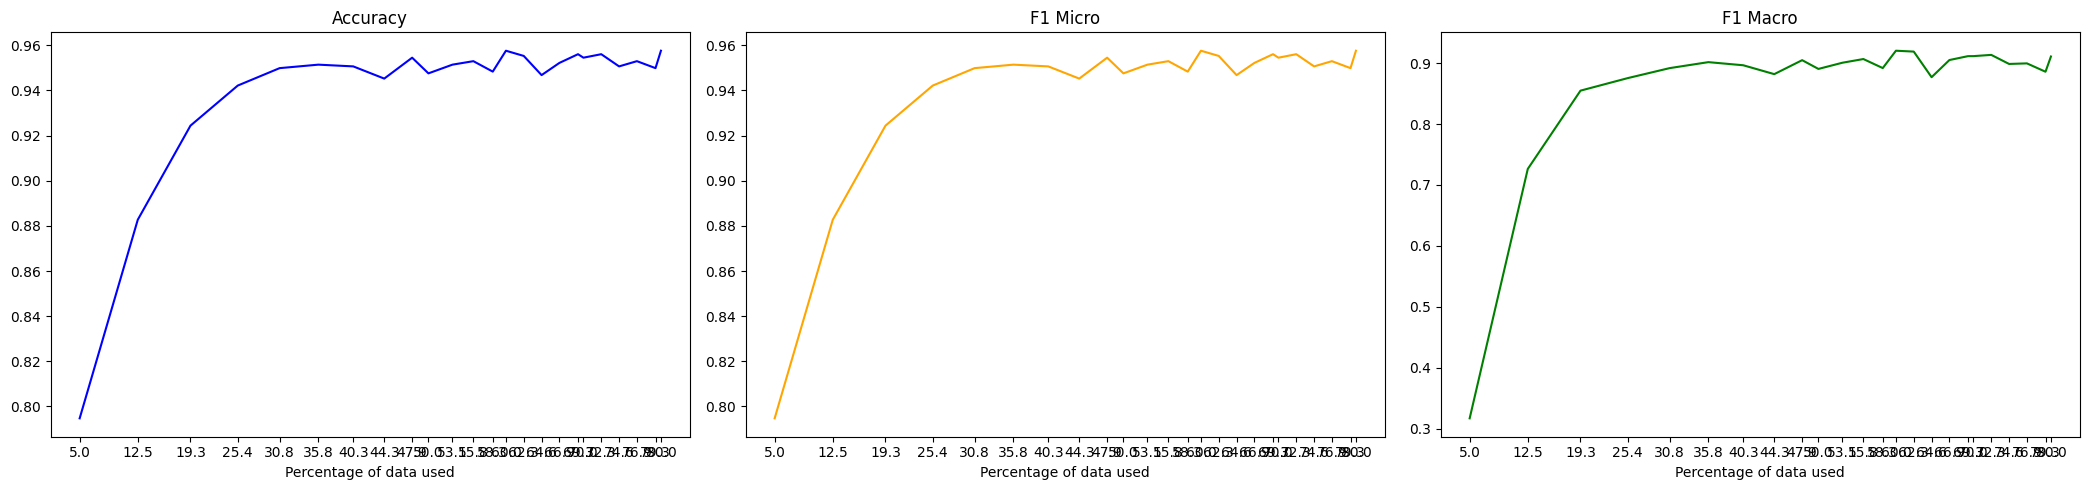

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6298, Accuracy: 0.7522, F1 Micro: 0.854, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5654, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5262, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4783, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4582, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4326, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4132, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4395, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7142, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5719, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6151, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5677, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5123, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5138, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4932, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3579, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6057, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5361, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5148, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4884, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4373, Accuracy: 0.8065, F1 Micro: 0.8903, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4155, Accuracy: 0.8185, F1 Micro: 0.8963, F1 Macro: 0.895
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3742, Accuracy: 0.8348, F1 Micro: 0.9046, F1 Macro: 0.9038
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3314, Accuracy: 0.849, F1 Micro: 0.9113, F1 Macro: 0.9102
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6275, Accuracy: 0.6949, F1 Micro: 0.6949, F1 Macro: 0.41
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5145, Accuracy: 0.6949, F1 Micro: 0.6949, F1 Macro: 0.41
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4566, Accuracy: 0.7401, F1 Micro: 0.7401, F1 Macro: 0.5503
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3623, Accuracy: 0.8757, F1 Micro: 0.8757, F1 Macro: 0.8534
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1606, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8945
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8945
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8905
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.8531, F1 Micro: 0.8531, F1 Macro: 0.8188
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5968, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5381, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4943, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4698, Accuracy: 0.8058, F1 Micro: 0.8901, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4195, Accuracy: 0.8274, F1 Micro: 0.9007, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3717, Accuracy: 0.8534, F1 Micro: 0.9144, F1 Macro: 0.9131
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3218, Accuracy: 0.8869, F1 Micro: 0.9324, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.266, Accuracy: 0.9115, F1 Micro: 0.946, F1 Macro: 0.9446
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6261, Accuracy: 0.6943, F1 Micro: 0.6943, F1 Macro: 0.4098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5183, Accuracy: 0.7598, F1 Micro: 0.7598, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3534, Accuracy: 0.8865, F1 Micro: 0.8865, F1 Macro: 0.8728
Epoch 4/10, Train Loss: 0.2091, Accuracy: 0.869, F1 Micro: 0.869, F1 Macro: 0.8404
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.8821, F1 Micro: 0.8821, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.9009
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8948
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8917
Epoch 10/10, Train Loss: 0.0818, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.578, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5021, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4797, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4128, Accuracy: 0.8423, F1 Micro: 0.9085, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3558, Accuracy: 0.8713, F1 Micro: 0.9236, F1 Macro: 0.9226
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.285, Accuracy: 0.9174, F1 Micro: 0.9497, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2321, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1872, Accuracy: 0.9457, F1 Micro: 0.9664, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.638, Accuracy: 0.6793, F1 Micro: 0.6793, F1 Macro: 0.4169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4196, Accuracy: 0.8692, F1 Micro: 0.8692, F1 Macro: 0.8472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2515, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.934
Epoch 4/10, Train Loss: 0.1424, Accuracy: 0.9367, F1 Micro: 0.9367, F1 Macro: 0.9271
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.9367, F1 Micro: 0.9367, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1413, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9392
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9214
Epoch 8/10, Train Loss: 0.0789, Accuracy: 0.9367, F1 Micro: 0.9367, F1 Macro: 0.9303
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9367, F1 Micro: 0.9367, F1 Macro: 0.9276
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9347

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5654, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5055, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4527, Accuracy: 0.817, F1 Micro: 0.8958, F1 Macro: 0.8943
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3792, Accuracy: 0.8676, F1 Micro: 0.9216, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3042, Accuracy: 0.9301, F1 Micro: 0.957, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2249, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1772, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1387, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5896, Accuracy: 0.7076, F1 Micro: 0.7076, F1 Macro: 0.5303
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4126, Accuracy: 0.8898, F1 Micro: 0.8898, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2339, Accuracy: 0.9364, F1 Micro: 0.9364, F1 Macro: 0.9293
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9221
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9178
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.9322, F1 Micro: 0.9322, F1 Macro: 0.9239
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.935
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9149
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9068
Epoch 10/10, Train Loss: 0.0705, Accuracy: 0.9322, F1 Micro: 0.9322, F1 Macro: 0.9265

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5431, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4887, Accuracy: 0.8028, F1 Micro: 0.889, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4237, Accuracy: 0.8557, F1 Micro: 0.9154, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3372, Accuracy: 0.9211, F1 Micro: 0.9519, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2524, Accuracy: 0.9457, F1 Micro: 0.9665, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1868, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1374, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.583, Accuracy: 0.7368, F1 Micro: 0.7368, F1 Macro: 0.6069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3445, Accuracy: 0.9271, F1 Micro: 0.9271, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1832, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9217
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9304
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9212
Epoch 6/10, Train Loss: 0.126, Accuracy: 0.8745, F1 Micro: 0.8745, F1 Macro: 0.8661
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.8785, F1 Micro: 0.8785, F1 Macro: 0.8695
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8955
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8946
Epoch 10/10, Train Loss: 0.0624, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.905

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5492, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4752, Accuracy: 0.8118, F1 Micro: 0.8932, F1 Macro: 0.8918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4204, Accuracy: 0.8542, F1 Micro: 0.9147, F1 Macro: 0.9138
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3221, Accuracy: 0.9249, F1 Micro: 0.954, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2326, Accuracy: 0.9427, F1 Micro: 0.9644, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1776, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1345, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.973
Epoch 8/10, Train Loss: 0.1119, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0877, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6393, Accuracy: 0.688, F1 Micro: 0.688, F1 Macro: 0.4196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3615, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9075
Epoch 3/10, Train Loss: 0.2422, Accuracy: 0.864, F1 Micro: 0.864, F1 Macro: 0.8557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1989, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9123
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1007, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9437
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9408
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9249
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9283
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9416
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9459

Sentiment 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5566, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4933, Accuracy: 0.8036, F1 Micro: 0.889, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.426, Accuracy: 0.8698, F1 Micro: 0.9231, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3198, Accuracy: 0.9345, F1 Micro: 0.9598, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2313, Accuracy: 0.9442, F1 Micro: 0.9652, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1685, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1301, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1057, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.973
Epoch 9/10, Train Loss: 0.0885, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5401, Accuracy: 0.8385, F1 Micro: 0.8385, F1 Macro: 0.8032
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2919, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9141
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8907
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.8962, F1 Micro: 0.8962, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9141
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9334
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9105
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9133
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9136
Epoch 10/10, Train Loss: 0.091, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9198

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5375, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4616, Accuracy: 0.8192, F1 Micro: 0.897, F1 Macro: 0.8957
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3911, Accuracy: 0.9077, F1 Micro: 0.9438, F1 Macro: 0.9419
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2555, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1835, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9736
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5266, Accuracy: 0.8333, F1 Micro: 0.8333, F1 Macro: 0.7904
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3231, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9302
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9386
Epoch 4/10, Train Loss: 0.1274, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.934
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9286
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9177
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9248
Epoch 8/10, Train Loss: 0.0757, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9226
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9305
Epoch 10/10, Train Loss: 0.0438, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9347

Sentiment analysis accuracy: 0.9444, F1 Micro: 0.944

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5343, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4643, Accuracy: 0.8207, F1 Micro: 0.8977, F1 Macro: 0.8967
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3787, Accuracy: 0.9137, F1 Micro: 0.9474, F1 Macro: 0.9456
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2628, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1902, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1384, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9737
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5163, Accuracy: 0.8347, F1 Micro: 0.8347, F1 Macro: 0.7936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2615, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.945
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9256, F1 Micro: 0.9256, F1 Macro: 0.9192
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9463, F1 Micro: 0.9463, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1278, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9491
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9298, F1 Micro: 0.9298, F1 Macro: 0.9231
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9298, F1 Micro: 0.9298, F1 Macro: 0.9231
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9463, F1 Micro: 0.9463, F1 Macro: 0.9406
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9322
Epoch 10/10, Train Loss: 0.0514, Accuracy: 0.9463, F1 Micro: 0.9463, F1 Macro: 0.9399

Sentiment analysis accuracy: 0.9545, F1 Micro: 0.954

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5338, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.475, Accuracy: 0.817, F1 Micro: 0.896, F1 Macro: 0.8947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.362, Accuracy: 0.9137, F1 Micro: 0.9478, F1 Macro: 0.9465
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2505, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9591, F1 Micro: 0.9746, F1 Macro: 0.9735
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9712
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9531, F1 Micro: 0.9704, F1 Macro: 0.968
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5162, Accuracy: 0.8615, F1 Micro: 0.8615, F1 Macro: 0.8314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2777, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9297
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9399
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9395
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9283
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9209
Epoch 10/10, Train Loss: 0.0548, Accuracy: 0.9154, F1 Micro: 0.9154, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5341, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4537, Accuracy: 0.8296, F1 Micro: 0.9022, F1 Macro: 0.9011
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3506, Accuracy: 0.9025, F1 Micro: 0.9402, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2503, Accuracy: 0.9501, F1 Micro: 0.9692, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1682, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9554, F1 Micro: 0.9717, F1 Macro: 0.9693
Higher F1 achieved, s

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5586, Accuracy: 0.8649, F1 Micro: 0.8649, F1 Macro: 0.8364
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2729, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.93
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9304
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9436
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9138
Epoch 8/10, Train Loss: 0.1029, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9391
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.915
Epoch 10/10, Train Loss: 0.0505, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4477, Accuracy: 0.8475, F1 Micro: 0.911, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3207, Accuracy: 0.9338, F1 Micro: 0.9588, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2186, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9719
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 10/10, Train Loss: 0.057, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5488, Accuracy: 0.8367, F1 Micro: 0.8367, F1 Macro: 0.7861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2915, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1595, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9335
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9463
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9362
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9339
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.918
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9292
Epoch 10/10, Train Loss: 0.053, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.925

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5368, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4419, Accuracy: 0.8624, F1 Micro: 0.919, F1 Macro: 0.9184
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3265, Accuracy: 0.9457, F1 Micro: 0.9664, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2156, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0778, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5898, Accuracy: 0.845, F1 Micro: 0.845, F1 Macro: 0.7984
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.939
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9344
Epoch 5/10, Train Loss: 0.1035, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9321
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9348
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9574, F1 Micro: 0.9574, F1 Macro: 0.9527
Epoch 8/10, Train Loss: 0.099, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9351
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.94
Epoch 10/10, Train Loss: 0.0681, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9117

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5257, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4515, Accuracy: 0.8631, F1 Micro: 0.9192, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3073, Accuracy: 0.9479, F1 Micro: 0.9679, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2027, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0593, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5176, Accuracy: 0.8631, F1 Micro: 0.8631, F1 Macro: 0.836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2555, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9309
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9276
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.928
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9125
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9354
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9324
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9324

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5262, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4337, Accuracy: 0.8676, F1 Micro: 0.922, F1 Macro: 0.9215
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2984, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.204, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Epoch 8/10, Train Loss: 0.0686, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5258, Accuracy: 0.8911, F1 Micro: 0.8911, F1 Macro: 0.8712
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2255, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.152, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9297
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9227
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.919
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9204
Epoch 7/10, Train Loss: 0.1009, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9145
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0951, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.935
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9177
Epoch 10/10, Train Loss: 0.0611, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9145

Sentiment analysis accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5278, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4322, Accuracy: 0.8601, F1 Micro: 0.9175, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3093, Accuracy: 0.942, F1 Micro: 0.9642, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1972, Accuracy: 0.9591, F1 Micro: 0.9746, F1 Macro: 0.9735
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4879, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2389, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9155
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1732, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.931
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9321
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.948
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9574, F1 Micro: 0.9574, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5282, Accuracy: 0.8021, F1 Micro: 0.8885, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4217, Accuracy: 0.8817, F1 Micro: 0.9297, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2855, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9744
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9568, F1 Micro: 0.9726, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9779
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9757
Epoch 10/10, Train Loss: 0.0465, Accuracy: 0.9583, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5527, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9276
Epoch 3/10, Train Loss: 0.1603, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9235
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1096, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9292
Epoch 6/10, Train Loss: 0.081, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9268
Epoch 7/10, Train Loss: 0.095, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9268
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9231
Epoch 10/10, Train Loss: 0.0447, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9186

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5338, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4356, Accuracy: 0.8824, F1 Micro: 0.9299, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2795, Accuracy: 0.9487, F1 Micro: 0.9683, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5099, Accuracy: 0.8842, F1 Micro: 0.8842, F1 Macro: 0.8716
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2384, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9274
Epoch 3/10, Train Loss: 0.1725, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.136, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9353
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1224, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9333
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.936
Epoch 10/10, Train Loss: 0.036, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5133, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4206, Accuracy: 0.8765, F1 Micro: 0.9262, F1 Macro: 0.9254
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2688, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1791, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.976
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5429, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8971
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2419, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9263
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9402
Epoch 4/10, Train Loss: 0.1442, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9244
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9248
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9409
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.928
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9168
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9276
Epoch 10/10, Train Loss: 0.0583, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9129

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5253, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4211, Accuracy: 0.91, F1 Micro: 0.9453, F1 Macro: 0.9442
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2637, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9729
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4843, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.9029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2244, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9404
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.173, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9439
Epoch 4/10, Train Loss: 0.1234, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9088
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9092
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9038
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9279
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9234
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9118
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8979

Sentiment analysis accuracy: 0.9504, F1 Micro: 0.9504,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.521, Accuracy: 0.8065, F1 Micro: 0.8908, F1 Macro: 0.8896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4042, Accuracy: 0.904, F1 Micro: 0.942, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2602, Accuracy: 0.9442, F1 Micro: 0.9648, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9781
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9805
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9786
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4446, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1943, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9393
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.931
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9358
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1128, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.944
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.095, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9479
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9317
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9317
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5245, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3956, Accuracy: 0.9278, F1 Micro: 0.9558, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2491, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1145, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9785
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9799
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4532, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9196
Epoch 2/10, Train Loss: 0.2032, Accuracy: 0.8798, F1 Micro: 0.8798, F1 Macro: 0.8732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1728, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.122, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9438
Epoch 6/10, Train Loss: 0.1069, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.928
Epoch 7/10, Train Loss: 0.0822, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9192
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9265
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9355
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9196

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.531, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4103, Accuracy: 0.9159, F1 Micro: 0.9489, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.25, Accuracy: 0.9435, F1 Micro: 0.9645, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4698, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2303, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1273, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9322
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0756, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9441
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9121
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9179
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.931
Epoch 10/10, Train Loss: 0.0433, Accuracy: 0.9387, F1 Micro: 0.9387, F1 

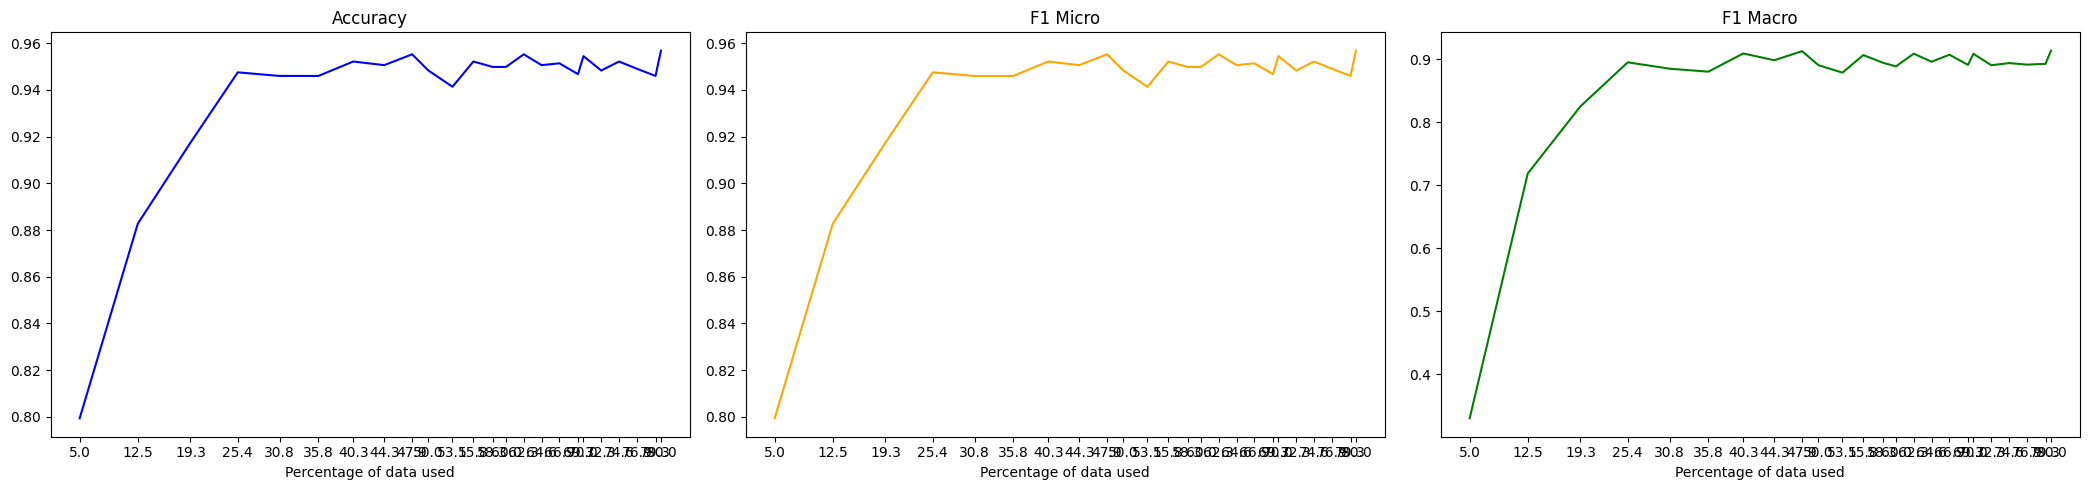

In [ ]:
active_learning(seeds[4], 4)